In [18]:
import input, text_processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot 

# Imports used in the tweet text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans, DBSCAN
# Imports used to build the autoencoder
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Flatten, Reshape

# Used to apply SOM networks
import somoclu

from wordcloud import WordCloud

#% load_ext autoreload
#% autoreload 2
% matplotlib inline

N_ENCODING_NEURONS = 32

In [ ]:
df = input.read_sample_dataset()
df.head()

,id_str,text,polarity,subjectivity,user_name,user_location,user_followers,created,retweet_count
0,1049367463295508480,Vamos eleger a educação para combater a violên...,0.0,0.0,Reinald71694969,"Xique-Xique, Brasil",4,2018-10-08 18:34:34.000000,0
1,1049367465778712576,#Bolsonaro2018 1⃣7⃣😎😎 https://t.co/jasNso3sBt,0.0,0.0,Constan_Daniel,NaN,147,2018-10-08 18:34:34.000000,0
2,1049367475190747137,RT @Horacio_Giusto: Lo sucedido ayer con #Bols...,0.0,0.0,herkow,Antártida,451,2018-10-08 18:34:37.000000,0
3,1049367475991863302,@g1 Então vai ser #BolsonaroPresidente17 @jair...,0.0,0.0,ArbexSilva,São Paulo,172,2018-10-08 18:34:37.000000,0
4,1049367482732097536,Bienvenidos a Charly y la fabrica de chocolate...,0.0,0.0,Pgascoin,NaN,155,2018-10-08 18:34:38.000000,0


In [11]:
cols = ['text', 'polarity', 'user_followers']
df = df[cols]
df = df[pd.notnull(df.text)]
df.head()

,text,polarity,user_followers
0,Vamos eleger a educação para combater a violên...,0.0,4
1,#Bolsonaro2018 1⃣7⃣😎😎 https://t.co/jasNso3sBt,0.0,147
2,RT @Horacio_Giusto: Lo sucedido ayer con #Bols...,0.0,451
3,@g1 Então vai ser #BolsonaroPresidente17 @jair...,0.0,172
4,Bienvenidos a Charly y la fabrica de chocolate...,0.0,155


In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=0.01, max_df=0.9, norm='l2', 
                        encoding='latin-1', 
                        strip_accents='unicode',
                        ngram_range=(1, 2), 
                        stop_words=text_processing.pt_br_stop_words)
input_array = tfidf.fit_transform(df.text).toarray()
words = tfidf.get_feature_names()
input_array.shape

(100000, 164)

In [62]:
input_neurons = input_array.shape[1]
encoding_neurons = N_ENCODING_NEURONS

compression_factor = float(input_neurons) / encoding_neurons
print("Compression factor: %s" % compression_factor)

autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Dense(4 * encoding_neurons, input_shape=(input_neurons,), activation='relu'))
autoencoder.add(Dense(2 * encoding_neurons, activation='relu'))
autoencoder.add(Dense(encoding_neurons, activation='relu'))

# Decoder Layers
autoencoder.add(Dense(2 * encoding_neurons, activation='relu'))
autoencoder.add(Dense(4 * encoding_neurons, activation='relu'))
autoencoder.add(Dense(input_neurons, activation='sigmoid'))


autoencoder.summary()

Compression factor: 72.625
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 128)               297600    
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_22 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_23 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_24 (Dense)             (None, 2324)              299796    
Total params: 618,164
Trainable params: 618,164
Non-trainable params: 0
___________________________________________

In [63]:
# save the encoding layer to use later as input to the clustering algorithm
input_layer = Input(shape=(input_neurons,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder = Model(input_layer, encoder_layer3(encoder_layer2(encoder_layer1(input_layer))))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2324)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               297600    
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
Total params: 307,936
Trainable params: 307,936
Non-trainable params: 0
_________________________________________________________________


In [64]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(input_array, input_array,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(input_array, input_array))
encoder.save("tweets_encoder.h5")


Train on 100000 samples, validate on 100000 samples
Epoch 1/50
100000/100000 [==============================] - 38s 375us/step - loss: 0.0570 - val_loss: 0.0087
Epoch 2/50
100000/100000 [==============================] - 42s 422us/step - loss: 0.0085 - val_loss: 0.0079
Epoch 3/50
100000/100000 [==============================] - 37s 369us/step - loss: 0.0074 - val_loss: 0.0071
Epoch 4/50
100000/100000 [==============================] - 43s 425us/step - loss: 0.0069 - val_loss: 0.0066
Epoch 5/50
100000/100000 [==============================] - 41s 411us/step - loss: 0.0061 - val_loss: 0.0057
Epoch 6/50
100000/100000 [==============================] - 39s 395us/step - loss: 0.0054 - val_loss: 0.0052
Epoch 7/50
100000/100000 [==============================] - 52s 523us/step - loss: 0.0050 - val_loss: 0.0048
Epoch 8/50
100000/100000 [==============================] - 46s 464us/step - loss: 0.0048 - val_loss: 0.0047
Epoch 9/50
100000/100000 [==============================] - 50s 504us/step -

In [5]:
encoder = load_model("tweets_encoder.h5")

clustering_input = encoder.predict(input_array)
words_occurrence = []
for i in range(0, len(input_array)):
    indexes = np.where(input_array[i] > 0)
    words_occurrence.append(np.take(words, indexes).tolist()[0])

clustering_input.shape

/home/vinicius/projects/Eleicoes2T/venv/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(100000, 32)

In [30]:
som_input = encoder.predict(input_array[0:1000])
n_rows, n_columns = N_ENCODING_NEURONS, N_ENCODING_NEURONS
som = somoclu.Somoclu(n_columns, n_rows)
print("Starting the training")
%time som.train(epochs=1000, data=som_input)
print ("Training finished!")

/home/vinicius/projects/Eleicoes2T/venv/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Starting the training
CPU times: user 3min 29s, sys: 752 ms, total: 3min 30s
Wall time: 1min 6s
Training finished!


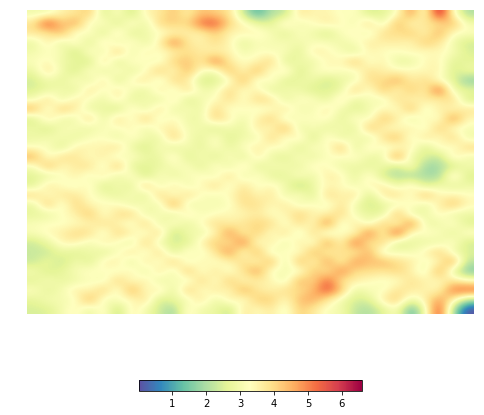

<module 'matplotlib.pyplot' from '/home/vinicius/projects/Eleicoes2T/venv/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [31]:
labels = range(0, som_input.shape[0])
som.view_umatrix(bestmatches=False, colorbar=True)

In [3]:
for i in range(0, len(labels)):
    print("{} - {}".format(i, words_occurrence[i]))

NameError: name 'labels' is not defined

In [15]:
#n_clusters = 2
#kmeans = KMeans(n_clusters = n_clusters, init = 'random')
#kmeans.fit_transform(input_array[0:10000])
#labels = kmeans.labels_
labels.shape

(10000,)

In [16]:
groups = [[]]*n_clusters
for i in range(0, len(labels)):
    groups[labels[i]].extend(words_occurrence[i])
    
groups[1]

['brasil',
 'combater',
 'educacao',
 'eleger',
 'haddadpresidente',
 'presidente',
 'presidente brasil',
 'primeiro',
 'professor',
 'vamos',
 'violencia',
 'bolsonaro2018',
 'bolsonaro',
 'con',
 'la',
 'lo',
 'bolsonaropresidente17',
 'entao',
 'jairbolsonaro',
 'vai',
 'bolsonaropresidente',
 'brasil',
 'la',
 'gente',
 'nao',
 'che',
 'un',
 'bolsonaro',
 'con',
 'dilma',
 'es',
 'han',
 'la',
 'los',
 'brasil',
 'brasil nao',
 'eleicao',
 'fico',
 'importante',
 'momento',
 'nao',
 'pessoas',
 'anche',
 'anche in',
 'aria',
 'aria nuova',
 'bolsonaro',
 'bolsonaro jairbolsonaro',
 'brasildecide',
 'brasile',
 'brasile si',
 'cambia',
 'cambia sinistra',
 'gobolsonarogo',
 'gobolsonarogo bolsonaro',
 'in',
 'in brasile',
 'jairbolsonaro',
 'jairbolsonaro brasildecide',
 'matteosalvinimi',
 'matteosalvinimi anche',
 'nuova',
 'nuova gobolsonarogo',
 'sconfitta',
 'sconfitta aria',
 'si',
 'si cambia',
 'sinistra',
 'sinistra sconfitta',
 'bolsonaro17',
 'bolsonaro17 nordeste17',
 '

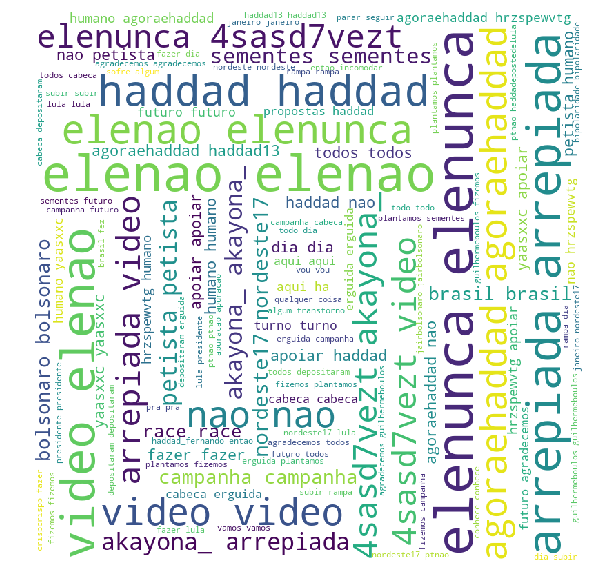

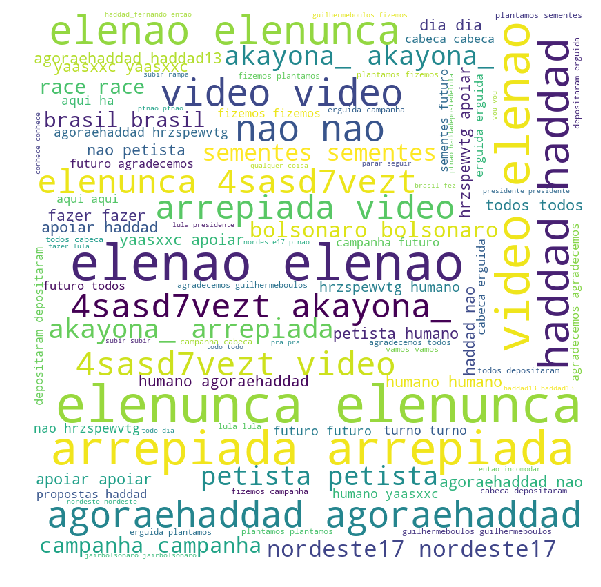

In [17]:
for group in groups:
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate(" ".join(group)) 

    # plot the WordCloud image                        
    plot.figure(figsize = (8, 8), facecolor = None) 
    plot.imshow(wordcloud) 
    plot.axis("off") 
    plot.tight_layout(pad = 0) 
    plot.show() 